In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display

sns.set(style="whitegrid")
columns=['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']
  

def analyze_wine(df, wine_name):
 
    print(f"\n\n===== Analysis for {wine_name} wine =====\n")
    print("Shape:", df.shape)
    df.head()

    dups = df.duplicated().sum()
    print("Number of duplicate rows:", dups) 
    df = df.drop_duplicates() 

    print(f"after remove duplicates:     rows:{df.shape[0]} columns: {df.shape[1]}")
  
    df.info()

    
    print(df.describe())
    print(df.isnull().sum())
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    for col in numeric_cols:
        print(f"---\nColumn: {col}")
        print("Stats:")
        print(df[col].describe())
        print("Nulls:", df[col].isnull().sum())
        print("Unique values:", df[col].nunique())
        print()

    
    categorical_cols = ['free sulfur dioxide','total sulfur dioxide']
    for col in categorical_cols:
        print(f"---\nColumn: {col}")
        print("Unique values/count:", df[col].nunique())
        print("Sample values:", df[col].unique()[:10])  
        print("Top 10 most common:")
        print(df[col].value_counts().head(10))
        print()

    skewness = df.skew()
    print(skewness.sort_values(ascending=False))

    
    # ۱) شناسایی ستون‌های با skewness بالا
    skew   = df.drop("quality", axis=1).skew()
    high   = skew[skew>1].index.tolist()

    print("High-skew cols (red):", high)

    # ۲) کپی دیتافریم و اعمال لگاریتم
    df_trans   = df.copy()

    df_trans[high]     = np.log1p(df_trans[high])

    # ۳) بازبینی چولگی پس از تبدیل
    print("After log1p transform (red):")
    print(df_trans.drop("quality", axis=1).skew().sort_values(ascending=False))


    sns.countplot(x="quality", data=df)
    plt.title("Distribution of Quality Red")
    plt.show()


    def remove_outliers_iqr(data, col):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return data[(data[col] >= lower) & (data[col] <= upper)]

    # مثال: حذف outlier در «residual sugar»
    df_clean = remove_outliers_iqr(df, "residual sugar")
    print("After outlier removal:", df_clean.shape)

    for col in ["residual sugar", "free sulfur dioxide", "total sulfur dioxide"]:
        df_clean[col] = np.log1p(df_clean[col])  # لگ( x + 1 )

    # دوباره چولگی را بررسی کنید
    print(df_clean[["residual sugar","free sulfur dioxide","total sulfur dioxide"]].skew())

    corr_red = df_clean .corr().abs()
    high_corr = np.where((corr_red>0.8) & (corr_red<1.0))
    high_pairs = [(corr_red.index[i], corr_red.columns[j], corr_red.iloc[i,j]) for i,j in zip(*high_corr)]
    print(high_pairs)
    
    X = df_clean.drop("quality", axis=1)
    y = df_clean["quality"]

    
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )

    
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Model coefficients:", model.coef_)
    print("Intercept:", model.intercept_)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 score: {r2:.2f}")

    residuals = y_test - y_pred

    # رسم نمودار پسماندها
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Quality")
    plt.ylabel("Residuals")
    plt.title(f"{wine_name} - Residuals Plot (Ridge)")
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.kdeplot(residuals,   color='blue', alpha=0.8)
    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.title('Distribution of Residuals (Kernel Density Plot)')
    plt.show()
 



===== Analysis for Red wine =====

Shape: (1599, 12)
Number of duplicate rows: 240
after remove duplicates:     rows:1359 columns: 12
<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.

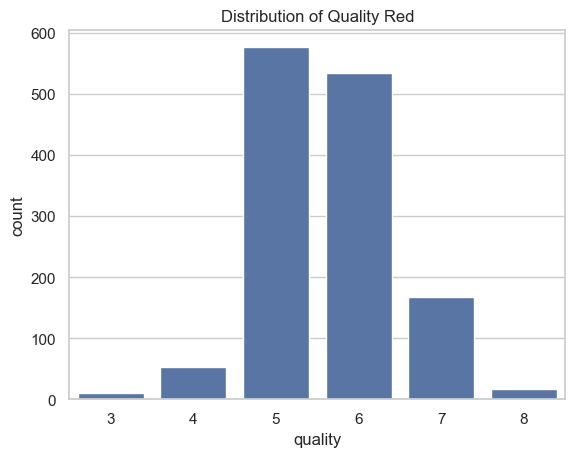

After outlier removal: (1233, 12)
residual sugar          0.166033
free sulfur dioxide    -0.134844
total sulfur dioxide   -0.065555
dtype: float64
[]
Model coefficients: [  0.02968564  -1.10046016  -0.15349593   0.17084753  -2.06262767
   0.05537469  -0.11480882 -24.92000371  -0.27503558   1.0361636
   0.28769235]
Intercept: 28.332070258241863
MAE: 0.50
RMSE: 0.65
R2 score: 0.32


C:\Users\R.Gh\AppData\Local\Temp\ipykernel_14016\3869098447.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = np.log1p(df_clean[col])  # لگ( x + 1 )


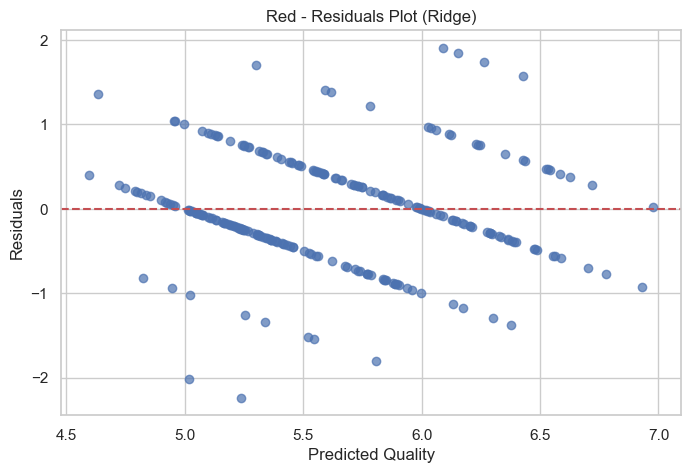

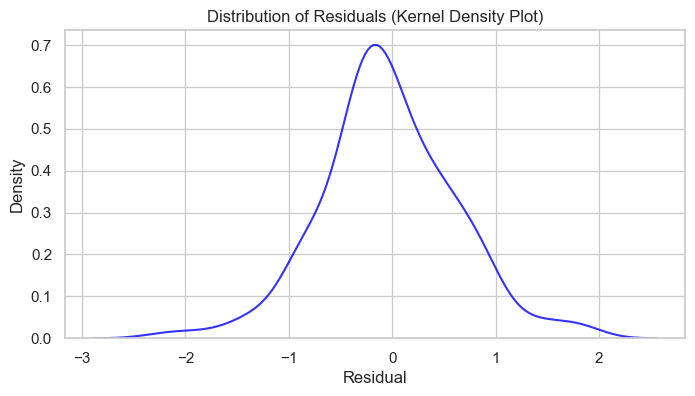



===== Analysis for Shite wine =====

Shape: (4898, 12)
Number of duplicate rows: 937
after remove duplicates:     rows:3961 columns: 12
<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3961 non-null   float64
 1   volatile acidity      3961 non-null   float64
 2   citric acid           3961 non-null   float64
 3   residual sugar        3961 non-null   float64
 4   chlorides             3961 non-null   float64
 5   free sulfur dioxide   3961 non-null   float64
 6   total sulfur dioxide  3961 non-null   float64
 7   density               3961 non-null   float64
 8   pH                    3961 non-null   float64
 9   sulphates             3961 non-null   float64
 10  alcohol               3961 non-null   float64
 11  quality               3961 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 40

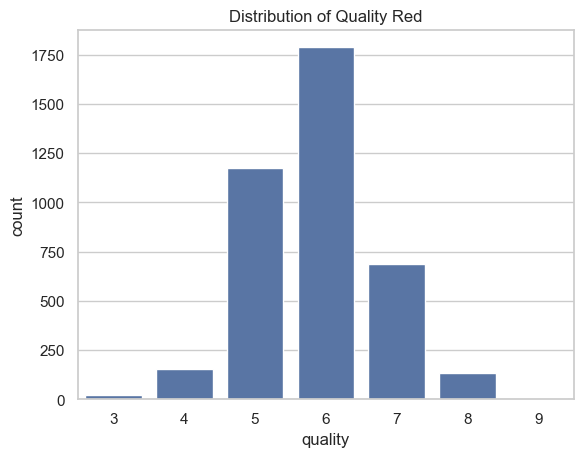

After outlier removal: (3945, 12)
residual sugar          0.096687
free sulfur dioxide    -0.795596
total sulfur dioxide   -0.906672
dtype: float64
[]
Model coefficients: [ 7.74136913e-02 -1.63452149e+00  3.38092526e-01  4.85647604e-01
 -7.00873510e-01  3.06323173e-01 -1.28400638e-01 -1.61533361e+02
  8.59781653e-01  6.13911224e-01  1.70561434e-01]
Intercept: 160.1253865439078
MAE: 0.56
RMSE: 0.74
R2 score: 0.30


C:\Users\R.Gh\AppData\Local\Temp\ipykernel_14016\3869098447.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = np.log1p(df_clean[col])  # لگ( x + 1 )


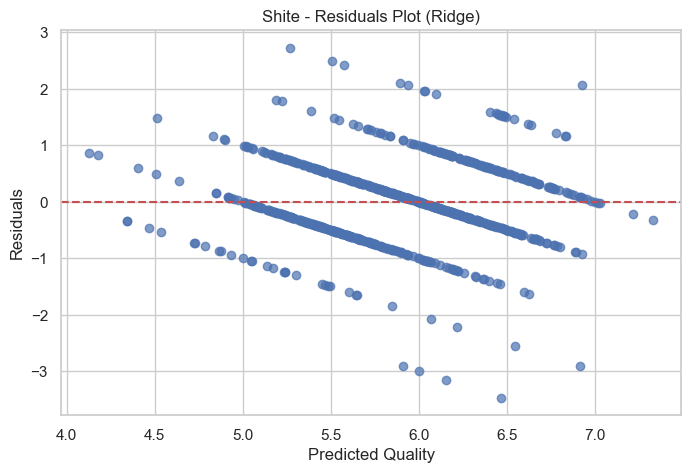

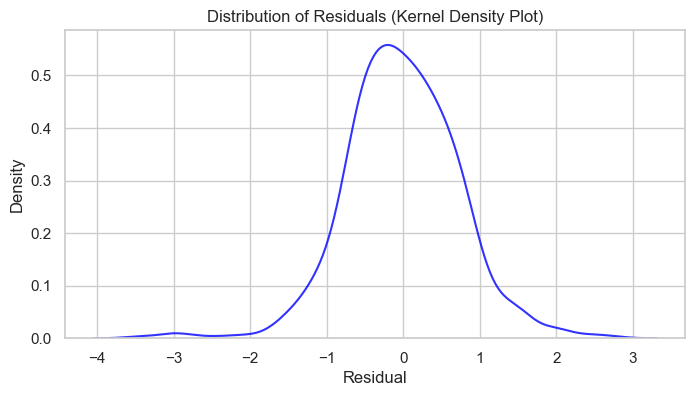

In [368]:
 
df_red = pd.read_csv('../data/winequality-red.csv', sep=';', encoding='utf-8')
df_white = pd.read_csv('../data/winequality-white.csv', sep=';', encoding='utf-8')

analyze_wine(df_red,"Red")
analyze_wine(df_white,"Shite")